In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline
import time
import keras
from enum import Enum
import keras
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras import layers
from math import floor, ceil
from random import sample

In [2]:
class CommentType(Enum):
    OTHER = 1
    WHITESPACE = 2
    PRAGMA = 3
    ENCODING = 4
    LICENSE = 5
    TYPEHINT = 6

class OtherType(Enum):
    MISC = 1
    RST = 2

class CleanAndCount:
    rst = 0
    punc = set(["+","-","=","_",">>",">>>","<<<","<<","*","'","\"","<",">","?","/","\\",",",".","!","@","#","$","%","^","&","(",")","[","]","{","}"])
    puncs = 0
    kinds = dict()
    def __init__(self):
        for k in CommentType:
            self.kinds[k] = 0
    def bumpkind(self,k):
        self.kinds[k] = self.kinds[k] + 1
    
    def sanitize_and_count(self,s):
        if s.isspace():
            self.bumpkind(CommentType.WHITESPACE)
            return None
        # TODO: Are there comments where c and c+'\n' are both in the data?
        s = s.strip()
        if (s.startswith("coding") or s.startswith("encoding")) and s.endswith("utf-8"):
            self.bumpkind(CommentType.ENCODING)
        elif (s.startswith("vim: ") or s.startswith("pylint: ") or s.startswith("noqa pylint: ") or s.startswith("pragma: ")):
            self.bumpkind(CommentType.PRAGMA)
        elif s.startswith("Licensed under "):
            self.bumpkind(CommentType.LICENSE)
        elif s.startswith("type:"):
            self.bumpkind(CommentType.TYPEHINT)
        else:
            self.bumpkind(CommentType.OTHER)
            if (".." in s and "::" in s):
                self.rst = self.rst + 1
            if (s in self.punc):
                self.puncs = self.puncs + 1
        return s
    # later should refactor to just clean and classify, so it can be reused for counting and filtering
    
    def __str__(self):
        return f"rst: {self.rst}, puncs: {self.puncs}, kinds: {(self.kinds)}"

class WordBox:
    def __init__(self, filename):
        self.filename = filename
        f = open(filename, "r", encoding="utf-8")
        lines = f.readlines()
        f.close()
        
        # Eventually the strings need to be embedded as integers, so we need to know what to do with them.  We need to know how many words there are, and we also need to know about outliers we can toss.
        # Note a subtlety with [str.split()](https://docs.python.org/3/library/stdtypes.html?highlight=split#str.split) below: passing space as the delimeter results in about 1.6 million empty splits. So it's important that we just use the general "consecutive whitespace" split default (no args). The original passed ```' '``` as the delimeter, which both lengthened lines and skewed distribution significantly.
        # find length of longest line, number of words total
        maxlen = 0
        wordcount = {'' : 0}
        for line in lines:
            words = line.split()
            maxlen = max(maxlen,len(words))
            for word in words:
                if word in wordcount:
                    wordcount[word] = wordcount[word] + 1
                else:
                    wordcount[word] = 1
        # Note that we haven't actually done further filtering; lots of these
        # "words" contain punctuation
        self.maxlen = maxlen
        self.wordcount = wordcount
        kvpairs = wordcount.items()
        self.kvsorted = sorted(kvpairs, key=lambda x: x[1], reverse=True)
        
        self.ndirect = len(lines)
        
        repeats = dict()
        for line in lines:
            if line in repeats:
                repeats[line] = repeats[line] + 1
            else:
                repeats[line] = 1
                
        self.repeats = repeats
        
        cac = CleanAndCount()
        cleaned = list()
        for l in lines:
            cleaned.append(cac.sanitize_and_count(l))
            
        # Let's see how many duplicate *cleaned* comments we have
        crepeats = dict()
        for line in cleaned:
            if line in crepeats:
                crepeats[line] = crepeats[line] + 1
            else:
                crepeats[line] = 1
        self.crepeats = crepeats
        
        cwordcount = {'' : 0}
        for line in cleaned:
            if line == None:
                continue
            words = line.split()
            maxlen = max(maxlen,len(words))
            for word in words:
                if word in cwordcount:
                    cwordcount[word] = cwordcount[word] + 1
                else:
                    cwordcount[word] = 1
        self.cwordcount = cwordcount
            
    def miscStats(self):
        vals = self.wordcount.values()
        print(len(vals))
        print(len(list(filter((lambda x: x > 1),vals))))
        print(len(list(filter((lambda x: x > 2),vals))))
        print(len(list(filter((lambda x: x > 3),vals))))
        print(len(list(filter((lambda x: x > 10),vals))))
        print(len(list(filter((lambda x: x > 100),vals))))
        print(str(self.ndirect)+" total lines")
        print(str(len(self.repeats))+" lines after removing exact duplicates")
        
        print("Raw comments: "+str((self.ndirect)))
        print("De-duplicated comments: "+str(len(self.repeats)))
        print("% duplicates: "+str(((self.ndirect-len(self.repeats))/self.ndirect)))

        print("De-duplicated *normalized* comments: "+str(len(self.crepeats)))
        print("% *normalized* duplicates: "+str(((self.ndirect-len(self.crepeats))/self.ndirect)))

        
    def plotTop(self):
        plt.hist(sorted(list(filter((lambda x: x > 100), self.wordcount.values()))),100,log=True)
    def showTopRepeats(self,n):
        print(sorted(self.repeats.items(), key=lambda x: x[1], reverse=True)[:n])
    def showTopCleanedRepeats(self,n):
        print(sorted(self.crepeats.items(), key=lambda x: x[1], reverse=True)[:n])

In [3]:
import os
import math

class Model:
    def __init__(self,wbox):
        self.sentences = []
        self.next_words = []
        self.maxlen = 10
        self.step = 2
        # Let's use the "cleaned" word counts (i.e., after deduplication)
        self.filtered = set(filter((lambda w: wbox.cwordcount[w] > 10), wbox.cwordcount.keys()))
        self.wbox = wbox
        # Choose a batch size depending on available physical RAM
        # memory calculation based on https://stackoverflow.com/questions/22102999/get-total-physical-memory-in-python/28161352#28161352
        # Based on number of bytes available, estimate how many inputs+outputs would fit in half of RAM
        # and take the next lowest power of 2 (the estimate is very rough) 
        #mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
        #estimated_inputs = mem_bytes/2/(self.maxlen*10001*8) # maxlen * |dict| * |uint8|
        #self.batch_size = 2**(math.floor(math.log2(estimated_inputs)))
        #print("Chose batch size "+str(self.batch_size)+" based on "+str(mem_bytes/(1024.**3))+"GB RAM")
        # Using a huge batch size makes the training process very slow (fewer updates to weights per epoch)
        # Using small batch sizes makes the gradient estimate bad, and loss only increases.
        self.batch_size = 512 #256
        self.epochs = 35

    def fitTokens(self):
        print("Building dictionary from Keras Tokenizer at "+time.asctime())
        tokenizer = Tokenizer(num_words = 10000) # Note this will be much smaller than the 121K above... Could try len(words), but need to one-hot encode output
        #tokenizer = Tokenizer(num_words = len(words)) # Note this will be much smaller than the 121K above...

        dropNone = list(filter((lambda x: x != None), self.wbox.crepeats))
        
        # This shuffles the list randomly, such that any slice of the result is a valid random subsample.
        # This means we can split this 80/10/10 training/validation/test by range.
        dropNone = sample(dropNone, len(dropNone))

        tokenizer.fit_on_texts(dropNone)

        # One-hot takes gobs of memory, so.... can't do that
        #one_hot_results = tokenizer.texts_to_matrix(dropNone, mode='binary')
        word_index2 = tokenizer.word_index
        print("Dictionary built from Keras Tokenizer at "+time.asctime())
        print('Found %s unique tokens.' % len(word_index2))
        print("Fixing for the fact that num_words doesn't work")

        # per https://github.com/keras-team/keras/issues/8092#issuecomment-372833486
        tokenizer.word_index={e:i for e,i in tokenizer.word_index.items() if i <= 10000} # word index is sorted most frequent to least
        tokenizer.word_index[tokenizer.oov_token] = 10000+1
        self.word_index2 = tokenizer.word_index
        print('Trimmed to %s unique tokens.' % len(self.word_index2))

        print("Generating training data at "+time.asctime())
        # Let's only select training sets where all words are learned for now, to keep data small. This will cause issues later.
        self.sentences = []
        self.next_words = []
        discards = 0
        sentences_with_discards = 0
        for l in dropNone: # self.crepeats with the Nones removed
            words = l.split()
            localDiscard = False
            for i in range(-self.maxlen+1,len(words)-self.maxlen, self.step):
                #if all((w in self.word_index2) for w in words[i: i+self.maxlen+1]):
                # We'll train on anything that predicts a word in the dictionary,
                # regardless of how many 'missing' words are in the input
                if words[i+self.maxlen] in self.word_index2:
                    if i >= 0:
                        self.sentences.append(words[i: i+self.maxlen])
                    else:
                        # Use a dummy sequence that won't be in the dictionary; punctuation was already filtered out
                        lst = (("@#$ "*(-i))).split()
                        lst.extend(words[:i+self.maxlen])
                        self.sentences.append(lst)
                    self.next_words.append(words[i+self.maxlen])
                else:
                    localDiscard = True
                    discards = discards + 1
            if localDiscard == True:
                sentences_with_discards = sentences_with_discards + 1
        print("Original number of input sentences: ",len(self.wbox.crepeats))
        print('Number of usable sequences:', len(self.sentences))
        print("Sentences with discards: ",sentences_with_discards)
        print("Total sequences discarded: ", discards)
        print("Done generating training data at "+time.asctime())

        
    class SentenceSequence(keras.utils.Sequence):
        """A TensorFlow Sequence class for piece-wise training without allocating arrays for the full dataset at once. Trades space for time."""
        def __init__(self, batch_size, sentences, next_words, word_index, maxlen):
            self.batch_size = batch_size
            # Shuffle sentences randomly
            #self.sentences = random.sample(sentences, len(sentences))
            # TODO: Need to do simultaneous shuffle on sentences and words! Or, put code to generate next_words here, *after* shuffling sentences
            # TODO: actually, the shuffle should be done outside this sequence: I can use random.sample on the whole of sentences, and that's supposed to be adequate to ensure any subslice is a valid random sample (https://docs.python.org/3/library/random.html#random.sample): so sample the whole population, then split 80/20 or 90/10 for validation, and put the validation in a second generator. For that matter, should also split off testing data that way.
            self.sentences = sentences
            self.next_words = next_words
            self.word_index = word_index
            self.maxlen = maxlen
            
        def __len__(self):
            return ceil(len(self.sentences) / self.batch_size)
        
        def __getitem__(self, idx):
            # Because the output uses one-hot encoding, need to use |dictionary|+1 so the last value is undef token
            # It feels a bit wasteful to reallocate on every call instead of reusing memory, but really the alternative requires explicitly resetting lots of things to 0, so it's probably not a terrible penalty
            if (idx+1)*self.batch_size >= len(self.next_words):
                x = np.zeros((len(self.sentences) % self.batch_size, self.maxlen), dtype=np.int)
                y = np.zeros((len(self.sentences) % self.batch_size, len(self.word_index)+1), dtype=np.int)
            else:
                x = np.zeros((self.batch_size, self.maxlen), dtype=np.int)
                y = np.zeros((self.batch_size, len(self.word_index)+1), dtype=np.int)
            arrindex = 0 #idx * self.batch_size
            for i in range(idx * self.batch_size, min((idx + 1) * self.batch_size, len(self.next_words)-1)):
                try:
                    if (i < len(self.next_words)):
                        for t, word in enumerate(self.sentences[i]):
                            # Tweak: Since I'm dropping most words for scaling, need to handle 'unmapped' words
                            x[arrindex, t] = self.word_index.get(word, len(self.word_index))
                        y[arrindex, self.word_index.get(self.next_words[i],len(self.word_index))] = 1
                    arrindex = arrindex + 1
                except IndexError:
                    print("Encountered the bug")
                    print(i)
                    print(idx)
                    print(arrindex)
                    print(len(self.next_words))
                    print((idx + 1) * self.batch_size < len(self.next_words))
            # TODO: instead of reshaping, allocate correct shape initially and reuse
            # Need tensors of the actual shape above for input to the embedding layer!
            #self.x = self.x.reshape(self.x.shape[0], 10, 1)
            return (x, y)
            
    def buildGenerators(self,train,valid):
        lastTraining = ceil(train/100.0*len(self.sentences))
        firstValid = lastTraining + 1
        lastValid = ceil((train+valid)/100.0*len(self.sentences))
        self.train = self.SentenceSequence(self.batch_size, self.sentences[:lastTraining], self.next_words[:lastTraining], self.word_index2, self.maxlen)
        self.valid = self.SentenceSequence(self.batch_size, self.sentences[firstValid:lastValid], self.next_words[firstValid:lastValid], self.word_index2, self.maxlen)
        self.test = self.SentenceSequence(self.batch_size, self.sentences[lastValid+1:], self.next_words[lastValid+1:], self.word_index2, self.maxlen)

    def buildLayers(self):
        self.model = keras.models.Sequential()
        self.model.add(layers.Embedding((len(self.word_index2)+1),32, input_length=self.maxlen)) # TODO: Is the 10000 here the vocab size, or number of samples?
        #self.model.add(layers.Flatten())
        #model.add(layers.LSTM(32, input_shape=(10,1)))
        #self.model.add(layers.LSTM(32, input_shape=(10,len(self.word_index2)+1), return_sequences=True))
        #self.model.add(layers.LSTM(32))
        self.model.add(layers.GRU(32, return_sequences=True))
        self.model.add(layers.GRU(32)) #, return_sequences=True))
        self.model.add(layers.Dropout(0.2))
        #self.model.add(layers.Dense(len(self.word_index2), activation='softmax'))
        # TimeDistributed is useful if we want to predice *sequences* rather than just one word
        #self.model.add(layers.TimeDistributed(layers.Dense(len(self.word_index2))))
        self.model.add(layers.Dense(len(self.word_index2)+1, activation='softmax'))
        #self.model.add(layers.Activation('softmax'))
        self.model.summary()
        
    def fitModelWithGenerator(self):
        optimizer = keras.optimizers.Adamax(lr=0.01)
        # So we're training on loss against predicting the next word
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer,
                           metrics=['accuracy', 'categorical_accuracy'])
        self.model.summary()
        self.history = self.model.fit(self.train,
                           epochs=self.epochs,
                           batch_size=self.batch_size, #32,
                           validation_data=self.valid)

In [4]:
import matplotlib.pyplot as plt

def plotLoss(m):
    plt.clf()
    loss = m.history.history['loss']
    val_loss = m.history.history['val_loss']

    epochs = range(1, len(loss)+1)

    loss = m.history.history['loss']
    val_loss = m.history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
        
def plotAccuracy(m):
    plt.clf()
    # no accuracy??? 
    acc = m.history.history['accuracy']
    val_acc = m.history.history['val_accuracy']
    epochs = range(1, len(acc)+1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def plotCatAccuracy(m):
    plt.clf()
    acc = m.history.history['categorical_accuracy']
    val_acc = m.history.history['val_categorical_accuracy']
    epochs = range(1, len(acc)+1)
    plt.plot(epochs, acc, 'bo', label='Training categorical acc')
    plt.plot(epochs, val_acc, 'b', label='Validation categorical acc')
    plt.title('Training and validation categorical accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Categorical Accuracy')
    plt.legend()
    plt.show()

In [5]:
def doItFlexibly(box,epochs):
    mod = Model(box)
    mod.epochs = epochs
    mod.fitTokens()
    mod.buildGenerators(70,15)
    mod.buildLayers()
    mod.fitModelWithGenerator()
    return mod
#advancedBox = WordBox("commentdata/advanced")
#advancedM = doItFlexibly(advancedBox,100)
#plotLoss(advancedM)

In [6]:
#plotAccuracy(advancedM)

Currently training only on sentences that are entirely within the top 10K words. Useful, but we'd like to also make predictions when some priming words are not mapped --- but we also don't want to have UNK be a valid prediction, because there will just be so many of them that it will heavily bias predictions towards UNK.
Advanced dataset loss hovering around 4.595, accuracy around 25%, when we can predict UNK and accept UNK inputs....

Now let's see now that we've switched to training on any inputs that predict some known word... (this will take longer to train since there are now many more valid training examples)

In [7]:
# TODO: currently hard-coded maxlen to 10...
# TODO: currently won't work unless there are exactly 10 words
def predictNext(model, primer):
    prime = primer.split()
    if (len(prime) > 10):
        return False
    # Will feed to batch prediction, with shape (None, maxlen)
    arr = np.zeros((1,10), dtype=np.int)
    for i in range(0,10):
        if prime[i] in model.word_index2:
            arr[0][i] = model.word_index2[prime[i]]
        else:
            arr[0][i] = len(model.word_index2)
    print(arr)
    return model.model.predict_on_batch(arr)
def maxVal(arr):
    tmp = 0
    for i in range(1,len(arr)):
        if arr[i] > arr[tmp]:
            tmp = i
    return tmp
def findWordFromIndexSlowly(model, idx):
    for key, value in model.word_index2.items():
        if value == idx:
            return key
    return False
def predictNextSplit(model, prime):
    # Will feed to batch prediction, with shape (None, maxlen)
    arr = np.zeros((1,model.maxlen), dtype=np.int)
    for i in range(0,model.maxlen):
        if prime[i] in model.word_index2:
            arr[0][i] = model.word_index2[prime[i]]
        else:
            arr[0][i] = len(model.word_index2)
    return model.model.predict_on_batch(arr)[0]
def next5(model, primer):
    prime = primer.split()
    if (len(prime) > model.maxlen):
        prime = prime[-10:]
    elif len(prime) < model.maxlen:
        prime = (("UNDEF "*(model.maxlen-len(prime)))+primer).split()
    orig = list()
    for i in range(0,5):
        w = findWordFromIndexSlowly(model, maxVal(predictNextSplit(model, prime)))
        prime.append(w)
        orig.append(prime.pop(0))
    orig.extend(prime)
    while (orig[0] == 'UNDEF'):
        orig.remove('UNDEF')
    return ' '.join(orig)

In [8]:
#print(advancedM.word_index2)
#print(next5(advancedM, "the method repeats"))
#print(next5(advancedM, "the method iterates over"))
#print(next5(advancedM, "sort the"))
#print(next5(advancedM, "the same"))
#print(next5(advancedM, "print the first parameter"))
#print(next5(advancedM, "standard input"))

Building dictionary from Keras Tokenizer at Fri Aug 28 01:17:00 2020
Dictionary built from Keras Tokenizer at Fri Aug 28 01:17:23 2020
Found 269952 unique tokens.
Fixing for the fact that num_words doesn't work
Trimmed to 10001 unique tokens.
Generating training data at Fri Aug 28 01:17:24 2020
Original number of input sentences:  932821
Number of usable sequences: 5869652
Sentences with discards:  549086
Total sequences discarded:  2992698
Done generating training data at Fri Aug 28 01:17:49 2020
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 32)            320064    
_________________________________________________________________
gru (GRU)                    (None, 10, 32)            6336      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_______________

8025/8025 [==============================] - 635s 79ms/step - loss: 5.0439 - accuracy: 0.2042 - categorical_accuracy: 0.2042 - val_loss: 4.9921 - val_accuracy: 0.2098 - val_categorical_accuracy: 0.2098
Epoch 28/100
8025/8025 [==============================] - 632s 79ms/step - loss: 5.0430 - accuracy: 0.2043 - categorical_accuracy: 0.2043 - val_loss: 4.9930 - val_accuracy: 0.2089 - val_categorical_accuracy: 0.2089
Epoch 29/100
8025/8025 [==============================] - 637s 79ms/step - loss: 5.0418 - accuracy: 0.2041 - categorical_accuracy: 0.2041 - val_loss: 4.9955 - val_accuracy: 0.2090 - val_categorical_accuracy: 0.2090
Epoch 30/100
8025/8025 [==============================] - 634s 79ms/step - loss: 5.0408 - accuracy: 0.2043 - categorical_accuracy: 0.2043 - val_loss: 4.9913 - val_accuracy: 0.2093 - val_categorical_accuracy: 0.2093
Epoch 31/100
8025/8025 [==============================] - 636s 79ms/step - loss: 5.0402 - accuracy: 0.2045 - categorical_accuracy: 0.2045 - val_loss: 4.9

8025/8025 [==============================] - 650s 81ms/step - loss: 5.0191 - accuracy: 0.2064 - categorical_accuracy: 0.2064 - val_loss: 4.9776 - val_accuracy: 0.2113 - val_categorical_accuracy: 0.2113
Epoch 66/100
8025/8025 [==============================] - 642s 80ms/step - loss: 5.0180 - accuracy: 0.2066 - categorical_accuracy: 0.2066 - val_loss: 4.9790 - val_accuracy: 0.2110 - val_categorical_accuracy: 0.2110
Epoch 67/100
8025/8025 [==============================] - 644s 80ms/step - loss: 5.0173 - accuracy: 0.2064 - categorical_accuracy: 0.2064 - val_loss: 4.9807 - val_accuracy: 0.2112 - val_categorical_accuracy: 0.2112
Epoch 68/100
8025/8025 [==============================] - 644s 80ms/step - loss: 5.0184 - accuracy: 0.2065 - categorical_accuracy: 0.2065 - val_loss: 4.9776 - val_accuracy: 0.2116 - val_categorical_accuracy: 0.2116
Epoch 69/100
8025/8025 [==============================] - 646s 80ms/step - loss: 5.0181 - accuracy: 0.2066 - categorical_accuracy: 0.2066 - val_loss: 4.9

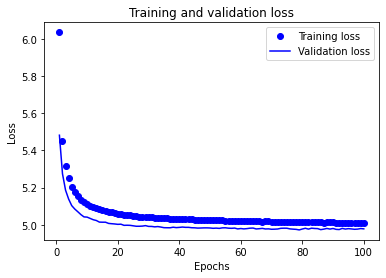

In [10]:
rawBox = WordBox("commentdata2/raw")
rawM = doItFlexibly(rawBox,100)
plotLoss(rawM)

In [11]:
#basicBox = WordBox("commentdata/basic")
#basicM = doItFlexibly(basicBox,100)
#plotLoss(basicM)

In [12]:
#javarawBox = WordBox("commentdata/javaRaw")
#javarawM = doItFlexibly(javarawBox,100)
#plotLoss(javarawM)

In [13]:
#javacleanBox = WordBox("commentdata/javaCleaned")
#javacleanM = doItFlexibly(javacleanBox,100)
#plotLoss(javacleanM)

In [14]:
#next5(advancedM, "the method repeats")

In [15]:
rawM.name = "Raw Python"
#basicM.name = "Basic Python"
#advancedM.name = "Advanced Python"
#javarawM.name = "Raw Java"
#javacleanM.name = "Clean Java"

In [16]:
import pickle
models = [rawM] #[rawM, basicM, advancedM] #, javarawM, javacleanM]
def predictAll(str):
    for m in models:
        print(m.name+": "+next5(m, str))
for m in models:
    prefix = m.name.replace(' ','_')
    m.model.save(prefix+"_shortgru.h5", save_format='h5')
    with open(prefix+"_shortgru.dict", "wb") as handle:
        pickle.dump(m.word_index2, handle)
    print('saved '+m.name)

saved Raw Python


In [17]:
for m in models:
    print(m.name)
    m.model.evaluate(m.test, batch_size=m.batch_size)

Raw Python
1720/1720 [==============================] - 89s 52ms/step - loss: 4.9736 - accuracy: 0.2121 - categorical_accuracy: 0.2121


In [18]:
#predictAll("the method repeats")

In [19]:
#predictAll("method iterates")

In [20]:
#predictAll("sorts the list and")

In [21]:
#predictAll("")

In [22]:
#predictAll("sort the array")

In [23]:
#predictAll("getter")

In [24]:
#predictAll("class")

In [25]:
#predictAll("throws an exception")

In [26]:
#predictAll("thows an exception if")

In [27]:
#predictAll("throws an exception if")

In [28]:
#predictAll("if an error is encountered")

In [29]:
#predictAll("logs all")

In [30]:
#for m in models:
#    prefix = m.name.replace(' ','_')
#    m.model.save(prefix+"_shortgru.h5", save_format='h5')
#    with open(prefix+"_shortgru.dict", "wb") as handle:
#        pickle.dump(m.word_index2, handle)
#    print('saved '+m.name)

In [31]:
class PredictionsOnly:
    def __init__(self, d, m):
        self.word_index2 = d
        self.model = m

def loadModel(prefix):
    d = Nil
    with open(prefix+"_shortgru.dict", "rb") as handle:
        d = pickle.load(handle)
    m = keras.models.load_model(prefix+"_shortgru.h5", save_format='h5')
    return PredictionsOnly(d, m)

In [32]:
#tmp = loadModel("Advanced_Python")
#next5(tmp, "throws an exception if")

In [34]:
with open("testPhrases","r") as p:
    phrases = p.readlines()

for m in models:
    prefix = m.name.replace(' ','_')
    with open(prefix+"_gen.txt","w") as out:
        for p in phrases:
            s = next5(m,p)
            print(s)
            out.write(s+"\n")

sets the background color of the file and the
notifications regarding tribler in the file and the path
builds a localization loss for the model and the
b x t x c c c c c
ok to pass value to the same value as
the form should not be a list of the
import scansingleapi scanpostmancollection import os import sys import
verify pricing file is not in the file and
issue using a bzfile method that is not called
we use get instead of the following code to
upload the cover thumbnail for the file and the
ensure that thresholded metrics are not in the same
latin small letter i in i in i in
this endpoint is responsible for the following tests for
test that biluocompatible tags are not in the same
a vfs that returns a list of the same
chunking not supported fall back to the same order
standard export converters to the same order as
removes from sprite group and the same value as
these derivers are not in the same order as
this method will always be called on the server
grammar example using sphinx an

remember that set members to the given list of
removing the top and the same value as a
logdebugno prefs file r and the function is used
returns character polish identity is a list of the
this is an ellipse with the same value as
an illegal configuration file or a list of the
returns the dtype for the given value of the
estimate the ideal throughput of the given function to
summary create new license and the given language and
create and return a list of the same of
keystroke a press of the message to be used
map asin codes to the file and the file
spec of the extendee file is not a list
special case for file and the same value in
not sure what we have to be a list
ok other merges into account in the current file
cosacosb can be combined with the same value as
which attributes to update the user to the user
list slicr configurations and the same type as the
manually import this hidden method on the current file
instruction movlpd groups sse and the same value as
handle the last unantic

creates a message chunk to be a list of
todo this was copied from the first test of
test with placeholders no longer have a single value
return npexpx pi for the given value of
testrecords frappegettestrecordsquality inspection of the current line of
common implementation of cabortconnection to be used to use
use path from entry for the given file and
deenumerate the result of the file is not
temp breakpoint names comma separated string or a list
returns the height and the first line of the
if there was a list of the same value
r return the identity of the given element of
next we build the first time to be a
reverse the hlines to the same order as the
runorder of means stop the connection to the given
wrapper around traceenumsampleelbo to be called by the first
container the container of the file to be used
inprocess task scheduler with the given state of the
return an iterator over the same order as a
delegate sign in and the default value is a
get the material group of the given pat

return a new bits to the given value of
having the dict keys and values are not in
versionadded an analogue of the error is raised if
flush the internal buffer to the current file and
consider whether expr is a list of the same
iterate over self examples of the same order as
lookup this grain values are not in the
asked for specific amount of time to be used
test if target temperature is not in the first
call workflows entry functionmethod is not a list of
draw only keypoints locationnot and the first row of
a message that this is a list of the
user remarks is not a list of the same
if we are not in the same order as
the default precision for the given value of the
set the maximum total number of time to be
support for niko home and the current directory is
fit estimator and transform the model to be used
use the templates to be used to use the
add self and other arguments to the same order
handle the case when the user is not in
switch between daily and and the data and the
test insta

nasty cases that used to make sure we have
calculates and returns a list of the data and
test with check mode for the given value of
these classes appear when the user is not in
now test that the same value is not in
sign not allowed to be a list of
create a user who is in the same order
this is to prevent the first time to be
hack perform surgery on the same order as the
center window on the top of the given node
add function constructor and the list of the
if retval was already present in the file and
surrounding space is optional in the form of the
from ruamelutilnew import convertversion from sympy import symbols from
get the latest data from the given file and
every module takes a list of the same of
adds values to the same order as the same
add add a register to the file and the
attempt to transform to the first time to be
traverse symbols in order to be a list of
mayavi plots require the same value as a list
with single byte string or string to be used
set second attribute to be

remove an address from the given file or a
r returns the coleman of the list of the
only used if cacerts is a list of the
remove nodedefault and edgedefault and the same value as
string stuff for automatic handling of the following tests
raised when a master is the same as the
normal gh gh not in other data and the
do provide keeptokens argument for the given value of
helper for total y and the same value as
f test joint hypothesis of the same size as
indexing test cases that are not in the
prevents the variable interfering and the same value as
none of the parameters to the given value of
add sighashall for testing the first and the first
on some platform stblocks and the following is a
always include weblate backend to use as a list
list list of identifier for the given file param
return a platform for the given file and the
remove existing entry in the file and the
maybe it doesnt have a new value in the
tests of reducedfunctionality for the given module of the
nor rn rm are not the